In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from mmseg.apis import inference_model, init_model
from mmseg.apis.inference import show_result_pyplot
from mmseg.structures import SegDataSample
from mmengine.structures import PixelData

from vUtils.utils import SegUtils

def img_batch_read(path):
    names = ["D04.jpg", "D05.jpg", "D06.jpg"]
    img_list = []
    for name in names:
        img_list.append(cv2.imread(os.path.join(path, name)))
    return img_list

def H_batch_read(path):
    names = ["D04.npy","D05.npy","D06.npy"]
    H_list=[]
    for name in names:
        H_list.append(np.load(os.path.join(path,name)))
    return H_list

def softmax(logits):
    return F.softmax(logits.permute(1, 2, 0), dim=-1).cpu().numpy()

def display_images(img_list):
    num_images = len(img_list)
    plt.figure(figsize=(15, 5))
    
    for i, img in enumerate(img_list):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off') 
        
    plt.show()


/home/gaobiaoli/miniconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/CV/gaobiaoli/project/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/CV/gaobiaoli/project/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: model/weight.pth


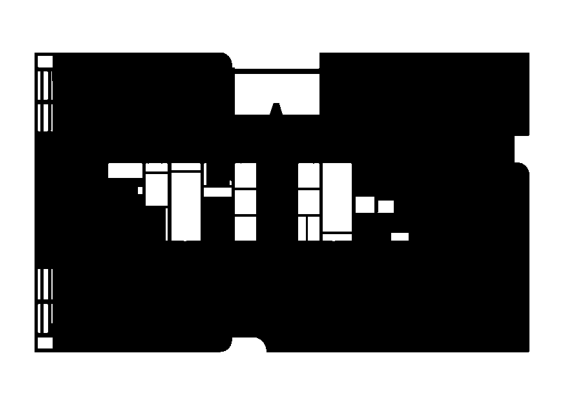

In [2]:
# model init
bimFloor = cv2.imread("base/target.png")
priorBIM=cv2.cvtColor(bimFloor, cv2.COLOR_BGR2GRAY)
_ , priorBIM = cv2.threshold(priorBIM, 200, 255, cv2.THRESH_BINARY)
mask = priorBIM<128
priorBIM = cv2.cvtColor(priorBIM, cv2.COLOR_GRAY2RGB)

checkpoint = "model/weight.pth"
config = "model/config.py"
device = "cuda:1"
model = init_model(config, checkpoint, device=device)

img_meta = dict(img_shape=bimFloor.shape)
baseResult = SegDataSample(metainfo=img_meta)
base_segmentations = PixelData(metainfo=img_meta)
baseResult.pred_sem_seg = base_segmentations

def postprocess(arrayList):
    arrayList=[i+1e-5 for i in arrayList]
    temp = SegUtils.DSFusion(arrayList)
    temp[:,:,0]=0 
    temp = SegUtils.denseCRF(prior_image=priorBIM,matrix=temp,parameter=[1,0,60,30,10])
    return temp.argmax(axis=-1)

display_images([priorBIM])

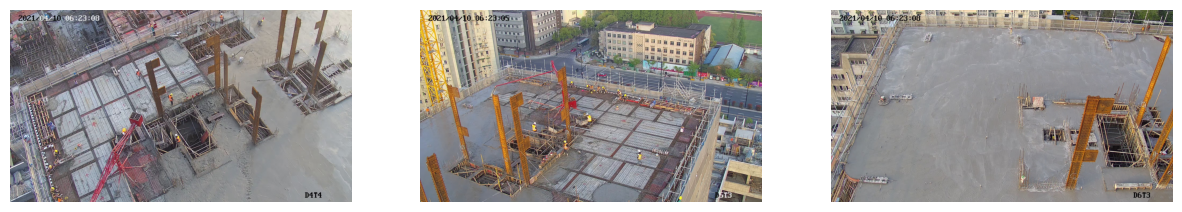

In [3]:
# read img and homography
path='data/0'
img_list=img_batch_read(path)
H_list=H_batch_read(path)
display_images(img_list)

/home/gaobiaoli/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


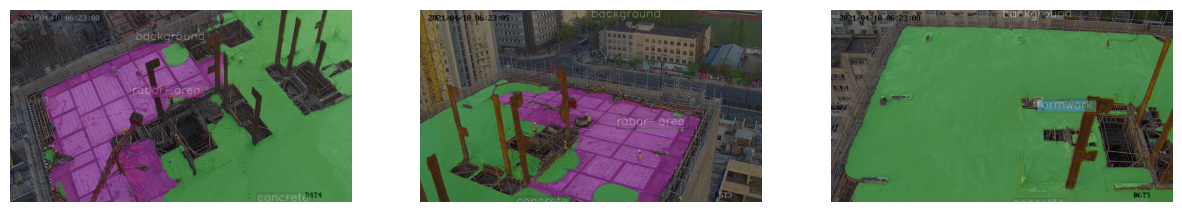

In [4]:
# semantic segmentation
results=inference_model(model, img_list)
seg_result=[]
for result,img in zip(results,img_list):
    baseResult.pred_sem_seg=result.pred_sem_seg
    seg_result.append(show_result_pyplot(model,img,baseResult,show=False))
display_images(seg_result)

/home/gaobiaoli/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/structures/pixel_data.py:83: UserWarning: The shape of value will convert from (596, 842) to (1, 596, 842)
  warnings.warn('The shape of value will convert from '


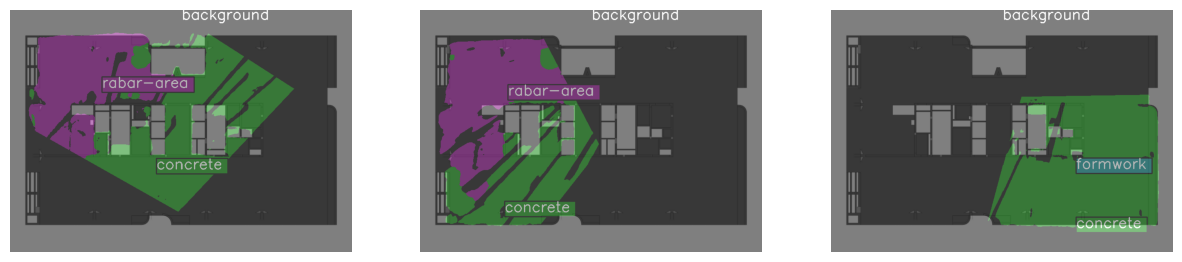

In [5]:
# homography transformation
trans_maps=SegUtils.batchWarpPerspective(
                arrayList = [item.seg_logits.data for item in results],
                H_List=H_list,
                shape=bimFloor.shape[0:2][::-1],
                prefunc_item=softmax,
                postfunc=None
                             )
trans_seg_result=[]
baseResult = SegDataSample(metainfo=img_meta)
base_segmentations = PixelData(metainfo=img_meta)
baseResult.pred_sem_seg = base_segmentations
for map in trans_maps:
    baseResult.pred_sem_seg.data=map.argmax(-1)
    trans_seg_result.append(show_result_pyplot(model,bimFloor,baseResult,show=False))
    
display_images(trans_seg_result)

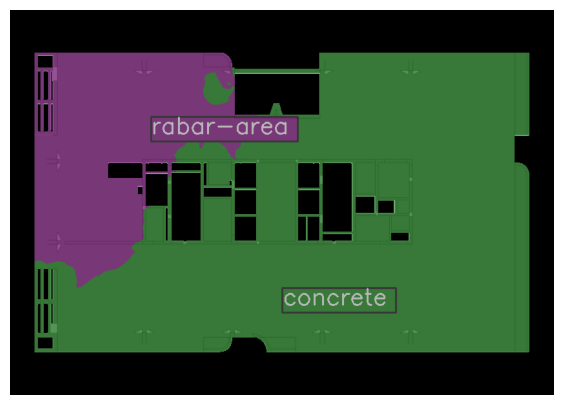

In [6]:
# fusion and inference
trans_map=SegUtils.batchWarpPerspective(
                arrayList = [item.seg_logits.data for item in results],
                H_List=H_list,
                shape=bimFloor.shape[0:2][::-1],
                prefunc_item=softmax,
                postfunc=postprocess
                             )
baseResult.pred_sem_seg.data=torch.tensor(trans_map).unsqueeze(0)
draw_img = show_result_pyplot(model, bimFloor, baseResult,show=False)
draw_img[~mask]=0
display_images([draw_img])